# **Clustering Assignment 2: Sessa Empirical Estimator (SEE)**
## 📝 **Instructions**
1) ✅**Read the Journals** about the Sessa Empirical Estimator.
2) ✅**Convert the R codes into Python** Codes (use jupyter notebook).
3) ✅**Perform the Sessa Empircal Estimator and generate some insights** using either: 
    - Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or 
    - Real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/),
4) ✅**Generate a new insight using the new clustering algorithm**
    - ✅ SEE uses K-Means clustering (again recall the disadvantages of K-Means)
    - ✅ Substitute a different clustering algorithm (DBSCAN)
5) ✅**Compare your results between**:
    - SEE using K-Means, and 
    - SEE using the clustering algorithm of your choice.
6) Deadline is this **Sunday, Feb 23,** ~~2022~~ **2025 at 11:59 pm**
7) ✅ Do this with your thesis partner.
8) ✅ You can use any A.I. assistant.
---

## 👩‍💻 **Converting R Code to Python Code**


### 🦺 Memory Leak Prevention
 - KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads
 - Settings the OMP_NUM_THREADS env to 2 or 1 fixes this

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

### 💥**Importing necessary libraries** 💥
#### Data Handling
1. `pandas`: Used for handling tabular data (like data frames in R). Equivalent to `dplyr` in R
2. `numpy`: Provides numerical operations, including array manipulations and mathematical functions.

In [2]:
import pandas as pd
import numpy as np

#### Data Visualization
1.  `matplotlib.pyplot`: Equivalent to R's `plot()`, used for static graphs.
2. `seaborn`: Used for statistical visualizations, like box plots (similar to R's `ggplot2`).


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Statistical Distribution
1. `ecdf`: It is used to analyze the distribution of the event.interval values in your dataset

In [4]:
from scipy.stats import ecdf

### Machine Learning (Clustering)
1. `KMeans`: Implements K-Means clustering (equivalent to R’s kmeans()).
2. `DBSCAN`: Alternative for K-Means clustering for SEE
3. `silhouette_score`: Calculates the silhouette
4. `StandardScaler`: Standardizes data (similar to R's scale()).

In [5]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#### **Summary Table of R-to-Python Imports**
| Functionality | R Equivalent | Python Equivalent |
| --- | --- | --- |
| Data Manipulation | `dplyr`, `data.table` | `pandas` |
| Numerical Computations | `base::log`, `scale()` | `numpy`, `scipy` |
| Plotting | `ggplot2`, `plot()`	| `seaborn`, `matplotlib.pyplot` |
| Event Interval | `event.interval` | `ecdf` |
| Clustering (K-Means) | `kmeans()` | `sklearn.cluster.KMeans` |
| Clustering (DBSCAN) | *-* | `sklearn.cluster.DBSCAN` | 
| Silhouette Score | *-* | `sklearn.metrics.silhouette_score` |
| Data Scaling | `scale()` | `sklearn.preprocessing.StandardScaler` |


### 💥**Main Functions**💥
1. `see(arg1, tidy)` – Implements the **Sessa Empirical Estimator (SEE)** using K-Means and DBSCAN (alt) clustering.

In [6]:
def see(arg1, tidy: pd.DataFrame, algorithm="kmeans"):
    C09CA01 = tidy[tidy["ATC"] == arg1].copy()
    
    # Take a random sequence of consecutive prescription in the dataset
    Drug_see_p0: pd.DataFrame = C09CA01.copy()
    Drug_see_p1: pd.DataFrame = C09CA01.copy()
    
    Drug_see_p1 = Drug_see_p1.sort_values(by=["pnr", "eksd"])
    Drug_see_p1["prev_eksd"] = Drug_see_p1.groupby("pnr")["eksd"].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=["prev_eksd"])
    
    # Sample one row per patient
    np.random.seed(1234)
    Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1 = Drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    
    # Calculate event interval
    Drug_see_p1["event.interval"] = (Drug_see_p1["eksd"] - Drug_see_p1["prev_eksd"]).dt.days
    Drug_see_p1["event.interval"] = Drug_see_p1["event.interval"].astype(float)

    # Drop zeroes
    Drug_see_p1 = Drug_see_p1[Drug_see_p1["event.interval"] > 0]
    
    # ECDF plot
    ecdf_values = ecdf(Drug_see_p1["event.interval"])
    x = np.sort(Drug_see_p1["event.interval"])
    y = ecdf_values.cdf.evaluate(x)
    
    dfper = pd.DataFrame({"x": x, "y": y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper["y"] <= 0.8]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(dfper["x"], dfper["y"], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot of log(event interval)
    d = np.log(Drug_see_p1["event.interval"])
    sns.kdeplot(d, label="Log(event interval)")
    plt.title("Log(event interval)")
    plt.show()
    
    # Scale the data for clustering
    a = dfper[["x"]].values
    a = StandardScaler().fit_transform(a)  # Standardize the data
    
    if algorithm == "kmeans":
        # Silhouette Score for K-means
        silhouette_scores = []
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
            cluster_labels = kmeans.fit_predict(a)
            silhouette_avg = silhouette_score(a, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        max_cluster = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
        
        # K-means Clustering
        kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
        dfper["cluster"] = kmeans.fit_predict(a)
    
    elif algorithm == "dbscan":
        # DBSCAN Clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples
        dfper["cluster"] = dbscan.fit_predict(a)
    
    else:
        raise ValueError("Invalid algorithm. Choose 'kmeans' or 'dbscan'.")
    
    # Summary statistics for clusters
    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"])
    cluster_summary = cluster_summary.reset_index()
    cluster_summary.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    print(cluster_summary)
    # Merge results with original data
    results = pd.merge(Drug_see_p1, cluster_summary, how="cross")
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"]) & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"], np.nan
    )
    results = results.dropna(subset=["Final_cluster"])
    
    # Get the most frequent cluster
    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    
    # Merge back to Drug_see_p1
    #Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1 = pd.merge(Drug_see_p1, results[["pnr", "Median", "Cluster"]], on="pnr", how="left")
    Drug_see_p1["Median"] = Drug_see_p1["Median"].fillna(t1_merged["Median"])
    Drug_see_p1["Cluster"] = Drug_see_p1["Cluster"].fillna(0)
    Drug_see_p1["test"] = Drug_see_p1["event.interval"] - Drug_see_p1["Median"]
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p1[["pnr", "Median", "Cluster"]], on="pnr", how="left")
    Drug_see_p0["Median"] = Drug_see_p0["Median"].fillna(t1_merged["Median"])
    Drug_see_p0["Cluster"] = Drug_see_p0["Cluster"].fillna(0)
    
    return Drug_see_p0

2. `see_assumption(tidy)` – Analyzes the assumptions behind the SEE, using **box plots and distribution analysis**.

In [7]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=["pnr", "eksd"])
    arg1["prev_eksd"] = arg1.groupby("pnr")["eksd"].shift(1)
    
    Drug_see2 = arg1.copy()
    Drug_see2["p_number"] = Drug_see2.groupby("pnr").cumcount() + 1
    Drug_see2 = Drug_see2[Drug_see2["p_number"] >= 2]
    Drug_see2 = Drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    Drug_see2["Duration"] = (Drug_see2["eksd"] - Drug_see2["prev_eksd"]).dt.days
    
    # Boxplot with medians
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=Drug_see2)
    
    medians_of_medians = Drug_see2.groupby("pnr")["Duration"].median().reset_index()
    plt.axhline(y=medians_of_medians["Duration"].median(), color="red", linestyle="--")
    plt.title("Duration by Prescription Number")
    plt.show()

### **Final Summary of Function Roles**
| **Function**       | **Purpose** |
|--------------------|------------|
| `see(arg1, tidy)` | Implements **Sessa Empirical Estimator (SEE)** using **K-Means and DBSCAN clustering** on prescription intervals. |
| `see_assumption(tidy)` | Analyzes **intervals between prescriptions** using **box plots and distribution analysis**. |


---
## 👨‍🏭 **Perform SEE on Simulated Data**

### **Extracting data from Library**

### **Import and clean extracted simulated data**

In [8]:
tidy = pd.read_csv('med_events.csv')
# add columns
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], errors='coerce')

---
### 🔄**Perform SEE on data with `K-means` clustering**

C:\Users\Matt\AppData\Local\Temp\ipykernel_26796\943813249.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


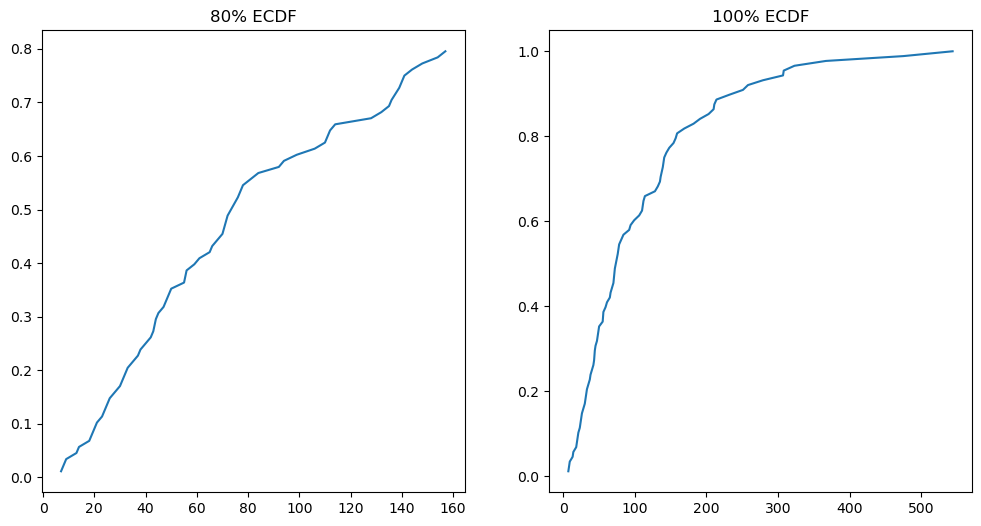

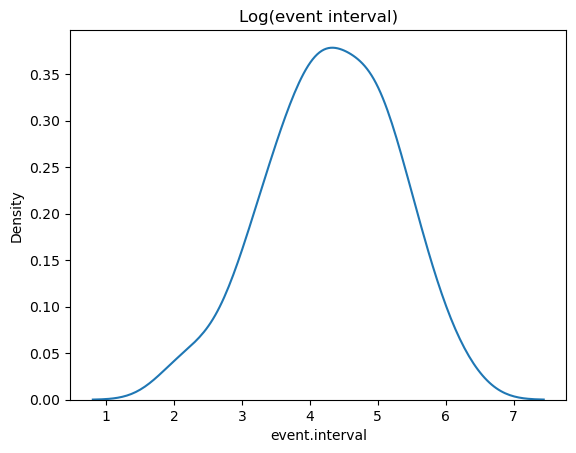

   Cluster  Minimum  Maximum  Median
0        0      7.0     84.0    44.0
1        1     92.0    157.0   133.5


C:\Users\Matt\AppData\Local\Temp\ipykernel_26796\943813249.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


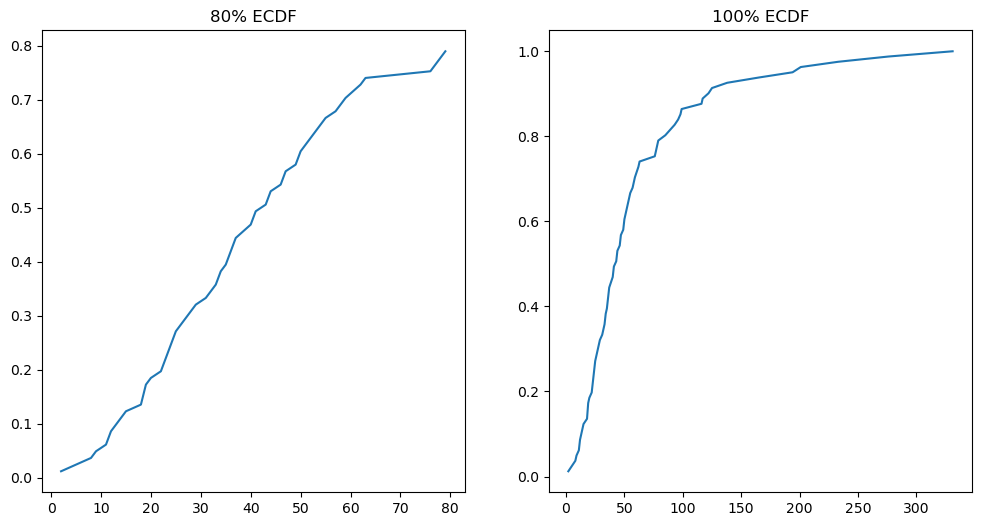

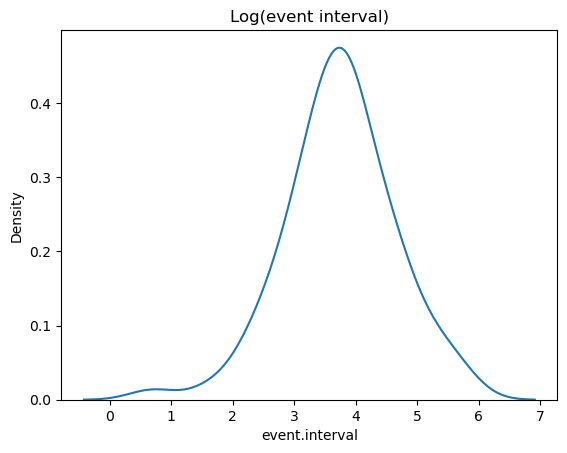

   Cluster  Minimum  Maximum  Median
0        0     18.0     22.0    19.0
1        1     53.0     58.0    54.0
2        2     31.0     37.0    34.5
3        3     76.0     79.0    78.0
4        4      8.0     15.0    12.0
5        5     46.0     50.0    48.0
6        6     23.0     29.0    25.0
7        7     59.0     63.0    62.0
8        8     40.0     44.0    41.0
9        9      2.0      5.0     3.5


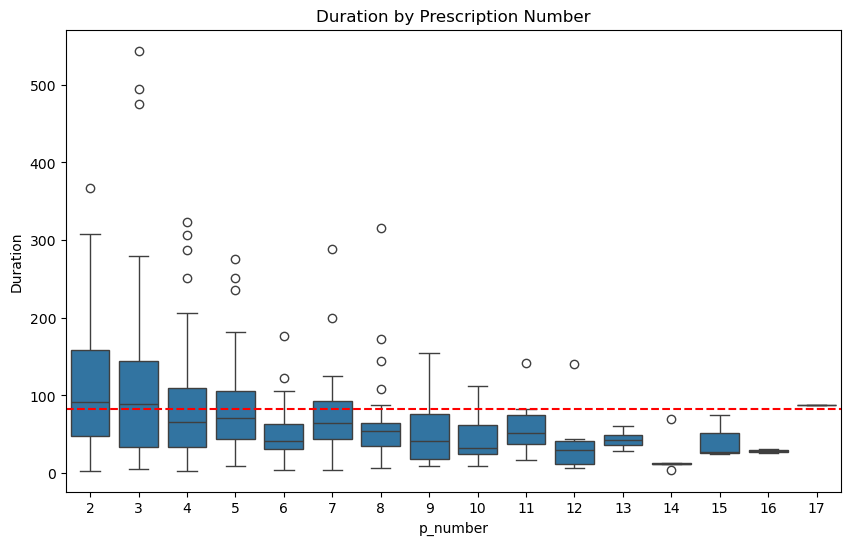

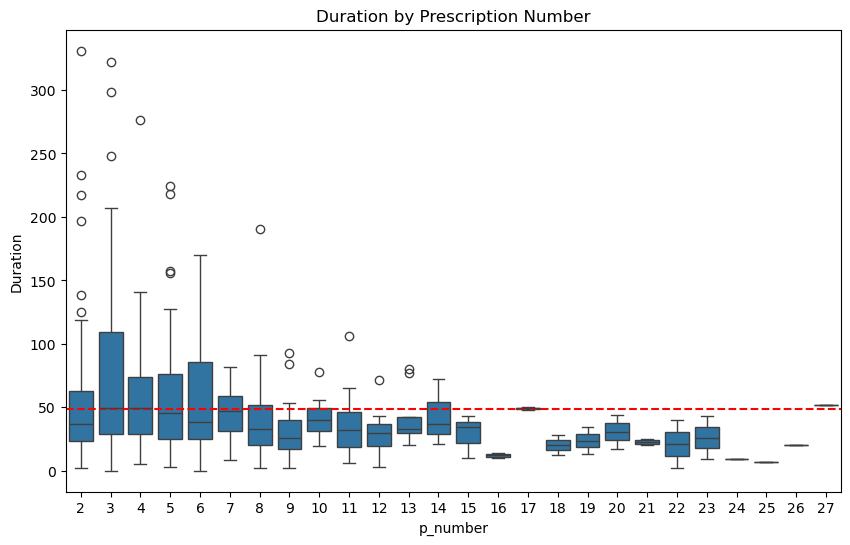

In [9]:
result_A_k = see('medA', tidy, "kmeans")
result_B_k = see('medB', tidy, "kmeans")

see_assumption(result_A_k)
see_assumption(result_B_k)

#### 📊 **Interpretation of K-Means Results**

##### 📌 BoxPlot  
- 📉 There's a general trend of **decreasing Duration** as prescription number increases.  
  - This suggests that as the prescription number increases, the duration between prescriptions tends to get shorter.  
- 🚨 All plots show **outliers**, particularly for lower prescription numbers.  
  - This indicates that some instances have **significantly longer durations** between early prescriptions.  
- 📏 The **variability of Duration** tends to decrease with increasing prescription numbers.  
  - This suggests that durations become more **consistent** in later prescriptions.  

##### 🔍 Clustering  
- **medA**  
  - Has **fewer, broader clusters** with **longer and more variable event intervals**.  
- **medB**  
  - Has **more, narrower clusters** with **shorter and more consistent event intervals**.  
  - medB's events are **far more regulated** than medA’s.  
  - medB has **more total clusters** than medA.  

#### 📈 **ECDF Analysis**  
##### **medA**  
- **80% ECDF reaches ~160**, **100% ECDF reaches ~500**  
- 🧐 **Interpretation:**  
  - The majority (80%) of event intervals in medA **fall within 0 to 160 days**.  
  - However, some **significantly longer intervals extend the range up to 500 days**.  
- ⚠️ **Implication:**  
  - **medA has more extreme outliers** or generally **longer event intervals** than medB.  

##### **medB**  
- **80% ECDF reaches ~100**, **100% ECDF reaches ~300**  
- 🧐 **Interpretation:**  
  - The majority (80%) of event intervals in medB **fall within 0 to 100 days**.  
  - The full range extends to **300 days**, meaning **there are longer intervals, but not as extreme as in medA**.  
- ✅ **Implication:**  
  - **medB has a more concentrated distribution of event intervals**.  
  - There are **fewer extreme outliers**, or the category generally has **lower duration**.  


### 🔄**Perform SEE on data with `DBSCAN`**

C:\Users\Matt\AppData\Local\Temp\ipykernel_26796\943813249.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


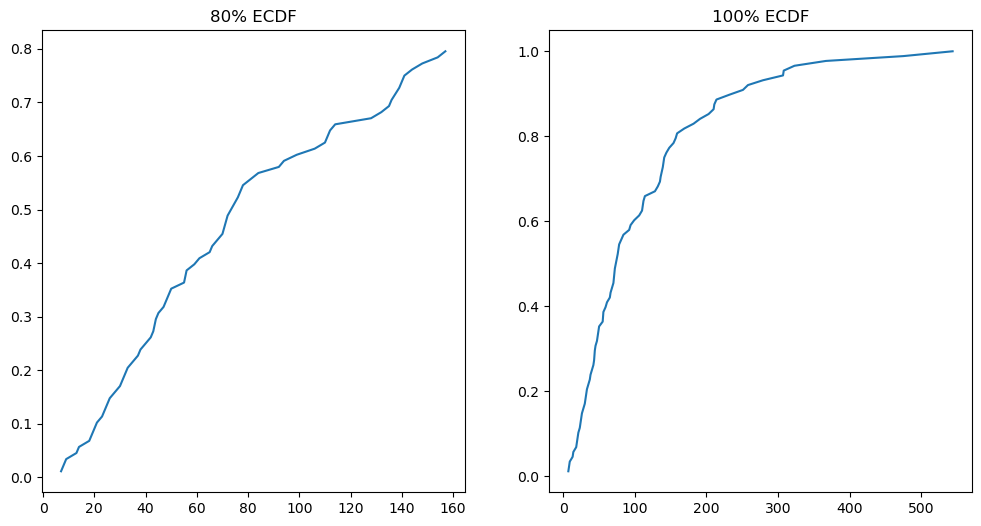

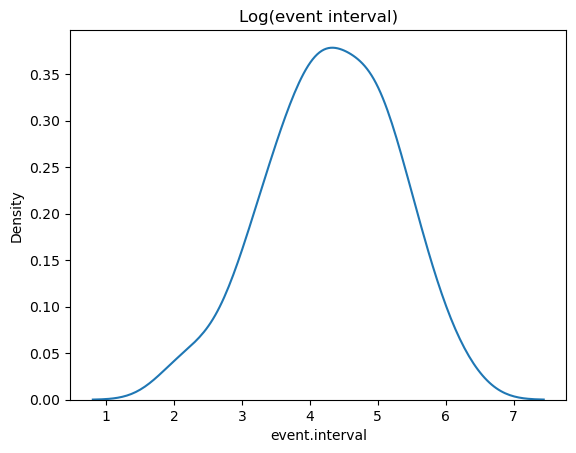

   Cluster  Minimum  Maximum  Median
0        0      7.0    157.0    60.0


C:\Users\Matt\AppData\Local\Temp\ipykernel_26796\943813249.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


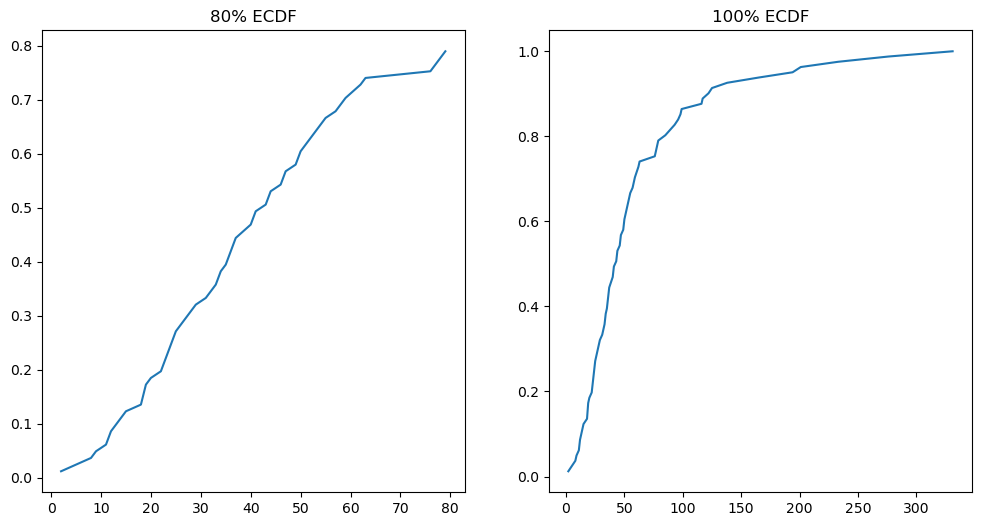

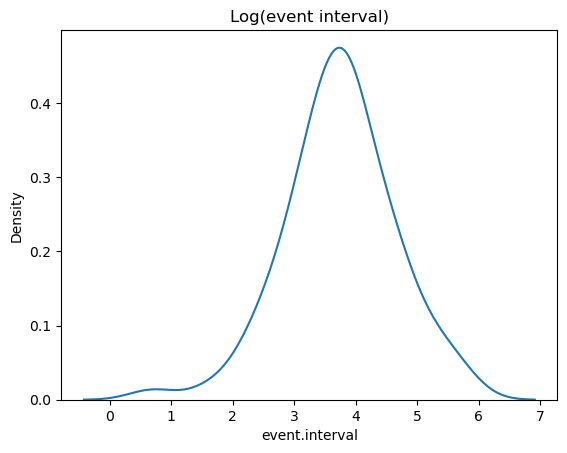

   Cluster  Minimum  Maximum  Median
0       -1     76.0     79.0    78.0
1        0      2.0     63.0    34.0


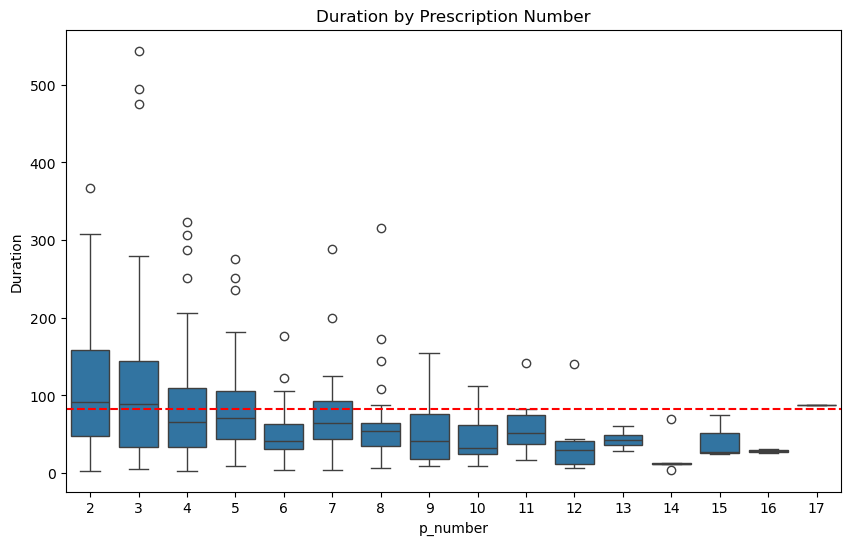

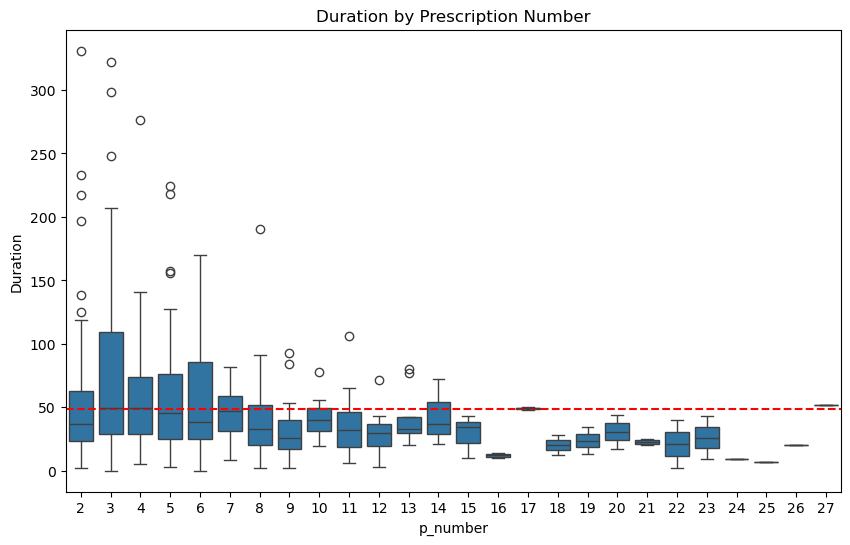

In [10]:
result_A_d = see('medA', tidy, "dbscan")
result_B_d = see('medB', tidy, "dbscan")

see_assumption(result_A_d)
see_assumption(result_B_d)

#### 📊 **Interpretation of DBSCAN Results**

##### 📌 BoxPlot  
- 📉 There's a general trend of **decreasing Duration** as prescription number increases.  
  - This suggests that as the prescription number increases, the duration between prescriptions tends to get shorter.  
- 🚨 All plots show **outliers**, particularly for lower prescription numbers.  
  - This indicates that some instances have **significantly longer durations** between early prescriptions.  
- 📏 The **variability of Duration** tends to decrease with increasing prescription numbers.  
  - This suggests that durations become more **consistent** in later prescriptions.  

##### 🔍 Clustering  
- **medA**  
  - Characterized by a **single, broad cluster** with **higher variability** and **longer event intervals**.  
- **medB**  
  - Has a **main cluster** with **lower variability** and **shorter event intervals**.  
  - Also includes a **small group of potential outliers**.  
- 📅 **medB's events happen more regularly than medA's events**.  

#### 📈 **ECDF Analysis**  
##### **medA**  
- **80% ECDF reaches ~160**, **100% ECDF reaches ~500**  
- 🧐 **Interpretation:**  
  - The majority (80%) of event intervals in medA **fall within 0 to 160 days**.  
  - However, some **significantly longer intervals extend the range up to 500 days**.  
- ⚠️ **Implication:**  
  - **medA has more extreme outliers** or generally **longer event intervals** than medB.  

##### **medB**  
- **80% ECDF reaches ~100**, **100% ECDF reaches ~300**  
- 🧐 **Interpretation:**  
  - The majority (80%) of event intervals in medB **fall within 0 to 100 days**.  
  - The full range extends to **300 days**, meaning **there are longer intervals, but not as extreme as in medA**.  
- ✅ **Implication:**  
  - **medB has a more concentrated distribution of event intervals**.  
  - There are **fewer extreme outliers**, or the category generally has **lower duration**.  


---
## 🧠 **Result Comparison**

### 🔢 **Cluster Count**
- **K-means** produced **two clusters** for medA and **ten clusters** for medB.
- **DBSCAN** produced **one cluster** for medA and **two clusters** for medB.
- This highlights a fundamental difference:  
  - **K-means** forces data points into a **pre-defined or optimized** number of clusters.  
  - **DBSCAN** identifies clusters based on **density** and can **label points as noise** (outliers).  
- **DBSCAN explicitly identifies outliers**, while **K-means assigns all points to clusters**.

### 📊 **Boxplot Insights**
- The **box plot visualizes the distribution** of "Duration" based on **raw prescription dates** and **patient numbers**.
- Since the boxplot is created from the **original data (not the clustered data)**, the clustering algorithm used has **no effect on the boxplot**.
- In all four plots, there's a **general trend of decreasing Duration** as `p_number` increases.  
  - This suggests that **as the prescription number increases, the duration between prescriptions tends to get shorter**.

### 📈 **Clustering Algorithm Usage**
- Even if the **ECDF plots look similar**, **K-means and DBSCAN provide different perspectives** on the data.  
- **ECDF Graphs Show Overall Distribution, Not Cluster Assignments.**

#### 🔷 **K-means**
- Provides insights into **finer-grained variations** in event intervals, revealing **more detailed subgroups**.
- Useful when you want to **explore different cluster counts** or **have a general idea of how many clusters to expect**.

#### 🔶 **DBSCAN**
- Provides insights into the **overall density structure** of the data and **identifies potential outliers**.
- Useful when you want to **focus on identifying broad patterns** and **avoid forcing data points into clusters**.

